# Estrategia de cruce de medias simples: ¿Qué medias móviles usar?

El cruce de medias o  Moving Average Crossover es una de las estrategias mas basicas en trading, ademas es un buen punto de partida de muchas estrategias mas complejas.  Utiliza dos promedios móviles para predecir las tendencias del mercado y los puntos de entrada/salida.

Para implementar esta estrategia, primero calculamos los promedios móviles a corto y largo plazo del precio de un valor. Estos promedios móviles pueden tener diferentes longitudes y están diseñados matemáticamente para tener diferentes variaciones y tasas de dirección. Cuando los dos promedios móviles se cruzan, es una señal para comprar o vender el valor.

El enfoque técnico de esta estrategia sugiere que cuando la media móvil a corto plazo (STMA por sus siglas en ingles) cruza por encima de la media móvil a largo plazo (LTMA por sus siglas en ingles), es una señal para comprar o ir en largo. Por el contrario, cuando el STMA cruza por debajo del LTMA, es una señal para vender. Este enfoque se basa en el principio del momentum, que establece que un precio que sube o baja en el período t probablemente continúe moviéndose en la misma dirección en el período t+1.

En este notebook, discutiremos cómo maximizar la rentabilidad con estrategias de cruce de medias móviles explorando diferentes combinaciones de STMA y LTMA. Al elegir longitudes de medias móviles correctas, es posible optimizar la estrategia y mejorar las posibilidades de éxito.

Primero, importamos las bibliotecas que vamos a utilizar para el análisis:

In [752]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

Usamos yfinance una biblioteca que permite acceder fácilmente a los datos financieros de Yahoo Finance. Con yfinance, podemos descargar datos de mercado históricos para acciones, opciones y divisas.

In [753]:
# Descargar los datos de cotización de ticker desde yfinance
tick = 'ARKK'
ticker = yf.Ticker(tick)
ticker_history = ticker.history(period='10y')

Para este ejemplo, analizamos 10 años del historial de precios diarios de ARKK, el ticker de ARK Innovation ETF, pero cambiando el valor de `tick` se pueden analizar otros valores.

In [754]:
# Calcular las medias móviles de 10 y 20 días
ticker_history['ma10'] = ticker_history['Close'].rolling(window=10).mean()
ticker_history['ma20'] = ticker_history['Close'].rolling(window=20).mean()


In [755]:
# Crear una columna con la señal de compra y venta
ticker_history['signal'] = 0.0
ticker_history['signal'] = np.where(ticker_history['ma10'] > ticker_history['ma20'], 1.0, 0.0)

In [756]:
# Calcular los retornos diarios de ticker
ticker_history['returns'] = ticker_history['Close'].pct_change()

In [757]:
# Calcular los retornos de la estrategia
ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

In [758]:
# Calcular el rendimiento acumulado de ticker y la estrategia
ticker_history['cumulative_returns'] = (1 + ticker_history['returns']).cumprod()
ticker_history['cumulative_strategy_returns'] = (1 + ticker_history['strategy_returns']).cumprod()

ticker_history['cumulative_strategy_returns'][-1]

2.682914903238644

Esto indica que el resultado de la estrategia en el periodo analizado es de 269,075%. En el mismo período, una estrategia de Comprar y Mantener hubiera tenido un retorno de 203.12%

Podemos crear un gráfico con los rendimientos acumulados para el ticker y la estrategia aplicada con Plotly.

In [759]:
# Crear un gráfico con el rendimiento acumulado de ticker y de la estrategia
fig = go.Figure()
fig.add_trace(go.Scatter(x=ticker_history.index, y=ticker_history['cumulative_returns'], name=tick,
                         line=dict(color='white', width=2)))
fig.add_trace(go.Scatter(x=ticker_history.index, y=ticker_history['cumulative_strategy_returns'], name='Estrategy',
                         line=dict(color='#22a7f0', width=2)))
fig.update_layout(title=('Moving average crossover strategy backtest in ' + tick),
                  xaxis_title='Date',
                  yaxis_title='Cumulative performance',
                  font=dict(color='white'),
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  legend=dict(x=0, y=1.2, bgcolor='rgba(0,0,0,0)'),
                  yaxis=dict(gridcolor='rgba(255,255,255,0.2)'),
                  xaxis=dict(gridcolor='rgba(255,255,255,0.2)'))
fig.update_xaxes(showgrid=True, ticklabelmode="period")
fig.update_yaxes(showgrid=True)
fig.show()

Pero el rendimiento no es lo único importante, también podemos analizar el drawdown de la estrategia.

El término Drawdown se refiere a la pérdida máxima que ha experimentado una cartera de inversión o un activo desde su valor máximo. Es la diferencia entre el punto más alto del valor de la inversión y el punto más bajo que alcanza antes de recuperarse.

El Drawdowne es importante porque brinda información sobre el riesgo y la volatilidad de una inversión. Un Drawdown alto indica que una inversión es más volátil y riesgosa, mientras que uno bajo sugiere una inversión más estable. Por lo tanto, esta medida puede ayudar a los inversores a administrar sus carteras y evaluar el riesgo potencial y las recompensas de sus inversiones.

Podemos estudiar el drawdown de la estrategia con el siguiente código:

In [760]:
# Calcular el máximo acumulado de los retornos de la estrategia hasta el momento
ticker_history['cumulative_strategy_max'] = ticker_history['cumulative_strategy_returns'].cummax()

# Calcular la caída actual de los retornos de la estrategia en relación con el máximo acumulado
ticker_history['cumulative_strategy_drawdown'] = (ticker_history['cumulative_strategy_returns'] / ticker_history['cumulative_strategy_max']) - 1

# Imprimir el drawdown actual
print('El drawdown actual de la estrategia es:', ticker_history['cumulative_strategy_drawdown'][-1])

El drawdown actual de la estrategia es: -0.5364383150776708


Pero, ¿y si cambiamos STMA a 20 y STMA a 40? ¿O STMA a 9 y STMA a 21? Teniendo en cuenta que los MA más comunes son 5, 7, 9, 10, 20, 21, 30, 40, 50, 100 y 200, podemos analizar los rendimientos y las pérdidas de diferentes MA combinados.

# Matriz retornos con distintas Medias Moviles
Para crear la matriz, primero desarrollamos un modelo similar de cruce MA

In [761]:
# Definir las medias móviles lenta y rápida
fast_ma = 10
slow_ma = 20

# Calcular las medias móviles de la estrategia
ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

# Crear una columna con la señal de compra y venta
ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

# Calcular los retornos diarios de ticker y de la estrategia
ticker_history['returns'] = ticker_history['Close'].pct_change()
ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']


Luego, creamos una matriz nula con diferentes combinaciones de promedios móviles usando un Pandas DataFrame:

In [762]:
# Crear una matriz de retornos con diferentes combinaciones de medias móviles
fast_ma_range = [5,7,9,10,20,21,30,40,50,100]
slow_ma_range = [7,9,10,20,21,30,40,50,100,200]
returns_matrix = pd.DataFrame(index=fast_ma_range, columns=slow_ma_range)
returns_matrix

,7,9,10,20,21,30,40,50,100,200
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como resultado, obtenemos una matriz nula de 10x10. Para llenarlo con los retornos hipotéticos de estrategias con diferentes combinaciones de MA usamos 2 bucles for:

In [763]:
for fast_ma in fast_ma_range:
    for slow_ma in slow_ma_range:
        # Calcular las medias móviles de la estrategia
        ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
        ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

        # Crear una columna con la señal de compra y venta
        ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

        # Calcular los retornos diarios de ticker y de la estrategia
        ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

        # Calcular el rendimiento acumulado de la estrategia
        cumulative_strategy_returns = (1 + ticker_history['strategy_returns']).cumprod()

        # Añadir el rendimiento acumulado de la estrategia a la matriz de retornos
        returns_matrix.loc[fast_ma, slow_ma] = cumulative_strategy_returns[-1]

returns_matrix

,7,9,10,20,21,30,40,50,100,200
5,1.873657,1.292148,0.939169,2.321924,2.126503,1.745325,1.877647,3.530262,2.558103,2.203429
7,1.0,0.697957,1.001405,2.14176,2.063261,2.147694,3.1382,4.212925,2.13334,1.829226
9,2.911645,1.0,1.460012,2.019798,2.510846,1.984789,3.329956,3.902465,2.345026,1.903372
10,2.031347,1.393277,1.0,2.682915,3.01052,1.961145,3.88895,3.600289,2.236316,1.989746
20,0.938248,0.994903,0.749,1.0,2.067089,2.942544,1.86597,2.712791,1.243767,1.560221
21,0.98932,0.812964,0.678031,0.987488,1.0,2.384003,1.694663,2.376381,1.29923,1.78229
30,0.982515,1.063157,1.075974,0.717115,0.885125,1.0,0.87195,1.494554,1.590657,2.440137
40,0.645446,0.608278,0.520844,1.085515,1.195245,2.322998,1.0,1.454145,2.03358,4.017928
50,0.491302,0.530387,0.574903,0.762984,0.870995,1.384906,1.423392,1.0,1.457118,4.514872
100,0.93289,0.848678,0.889933,1.600116,1.531808,1.251163,0.978654,1.365827,1.0,4.084257


Ahora tenemos una matriz completa con retornos de estrategias con diferentes combinaciones de MA. Para visualizar podemos crear un mapa de calor usando la biblioteca Seaborn:

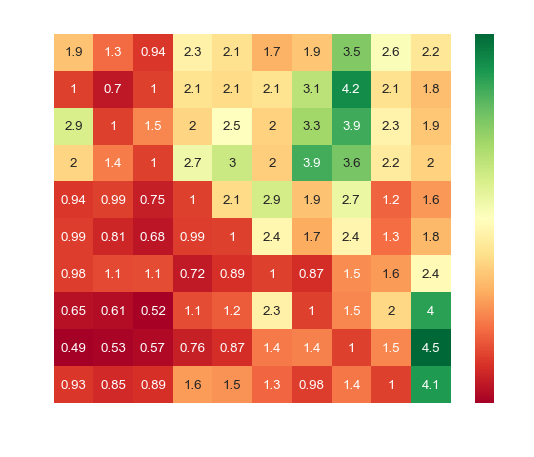

In [765]:
# Haga una copia de return_matrix y convierta el índice y las columnas al tipo de cadena
valores = returns_matrix.copy()
valores.index = valores.index.astype(str)
valores.columns = valores.columns.astype(str)

#valores = returns_matrix.values
valores = valores.astype(float)

# Cambiamos el estilo del gráfico y establecemos el esquema de color predeterminado
plt.style.use('dark_background')
sns.set_palette("bright")

sns.heatmap(valores, annot=True, cmap='RdYlGn')

# Agregamos títulos a los ejes
plt.xlabel('Media Movil Lenta', fontsize=12, color='white')
plt.ylabel('Media Movil Rapida', fontsize=12, color='white')

plt.title('Mapa de calor de rendimientos', fontsize=16, color='white')

# Cambiamos el tamaño de la fuente a 10 y el color a blanco
sns.set(font_scale=0.8, rc={'text.color':'white', 'axes.labelcolor':'white', 'xtick.color':'white', 'ytick.color':'white'})

# Cambiamos el color de fondo del gráfico a negro
fig = plt.gcf()
fig.set_facecolor('#0000')

plt.show()


Como podemos ver en el gráfico anterior, las estrategias con diferentes combinaciones de medias móviles pueden lograr rendimientos desiguales.
Las 2 mejores combinaciones para el período analizado son:
+ STMA:50, LTMA:200 con una rentabilidad acumulada de 4,5 (451,48 %)
+ STMA:7, LTMA:50 con una rentabilidad acumulada de 4,2 (421,29 %)

200, 50 y 40 parecen ser buenas opciones para elegir como LTMA para este valor pero no está demasiado claro elegir un buen candidato para STMA.

Complementariamente, podemos analizar los drawdowns para diferentes combinaciones de medias móviles como hicimos con los rendimientos.

# Matriz de drawdowns con diferentes medias móviles

Creamos otra matriz nula con diferentes combinaciones de promedios móviles usando un Pandas DataFrame:

In [771]:
# Definir las medias móviles lenta y rápida
fast_ma = 10
slow_ma = 20

# Calcular las medias móviles de la estrategia
ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

# Crear una columna con la señal de compra y venta
ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

# Calcular los retornos diarios de ticker y de la estrategia
ticker_history['returns'] = ticker_history['Close'].pct_change()
ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

# Crear una matriz de retornos con diferentes combinaciones de medias móviles
fast_ma_range = [5,7,9,10,20,21,30,40,50,100]
slow_ma_range = [7,9,10,20,21,30,40,50,100,200]
dd_matrix = pd.DataFrame(index=fast_ma_range, columns=slow_ma_range)
dd_matrix

,7,9,10,20,21,30,40,50,100,200
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como resultado, obtenemos una matriz nula de 10x10. Para llenarlo con los drawdowns hipotéticos de estrategias con diferentes combinaciones de MA usamos 2 bucles for:

In [768]:
for fast_ma in fast_ma_range:
    for slow_ma in slow_ma_range:
        
        # Calcular las medias móviles de la estrategia
        ticker_history['fast_ma'] = ticker_history['Close'].rolling(window=fast_ma).mean()
        ticker_history['slow_ma'] = ticker_history['Close'].rolling(window=slow_ma).mean()

        # Crear una columna con la señal de compra y venta
        ticker_history['signal'] = np.where(ticker_history['fast_ma'] > ticker_history['slow_ma'], 1.0, 0.0)

        # Calcular los retornos diarios de ticker y de la estrategia
        ticker_history['strategy_returns'] = ticker_history['signal'].shift(1) * ticker_history['returns']

        # Calcular el rendimiento acumulado de la estrategia
        ticker_history['cumulative_strategy_returns'] = (1 + ticker_history['strategy_returns']).cumprod()

        # Calcular el máximo acumulado de los retornos de la estrategia hasta el momento
        ticker_history['cumulative_strategy_max'] = ticker_history['cumulative_strategy_returns'].cummax()

        # Calcular la caída actual de los retornos de la estrategia en relación con el máximo acumulado
        ticker_history['cumulative_strategy_drawdown'] = (ticker_history['cumulative_strategy_returns'] / ticker_history['cumulative_strategy_max']) - 1

        # Añadir el drawdown acumulado de la estrategia a la matriz de drawdowns
        dd_matrix.loc[fast_ma, slow_ma] = ticker_history['cumulative_strategy_drawdown'][-1]

dd_matrix

,7,9,10,20,21,30,40,50,100,200
5,-0.60173,-0.603356,-0.710021,-0.614655,-0.624545,-0.583668,-0.617917,-0.406518,-0.504459,-0.455986
7,0.0,-0.760709,-0.731297,-0.595215,-0.637862,-0.513102,-0.392225,-0.25876,-0.514019,-0.470194
9,-0.019077,0.0,-0.538648,-0.621954,-0.595057,-0.52998,-0.322519,-0.350306,-0.431129,-0.432458
10,-0.126449,-0.474507,0.0,-0.536438,-0.504627,-0.546622,-0.274974,-0.436767,-0.478124,-0.43303
20,-0.48212,-0.514079,-0.633746,0.0,-0.518999,-0.572562,-0.589773,-0.444073,-0.575775,-0.451498
21,-0.48383,-0.582701,-0.659665,-0.537042,0.0,-0.554544,-0.571365,-0.428824,-0.53091,-0.441837
30,-0.531542,-0.556044,-0.532857,-0.589692,-0.585869,0.0,-0.605746,-0.443737,-0.47086,-0.359518
40,-0.619607,-0.664565,-0.665616,-0.5515,-0.550952,-0.506086,0.0,-0.442973,-0.382272,-0.320052
50,-0.695809,-0.635263,-0.587415,-0.616542,-0.626567,-0.602488,-0.580476,0.0,-0.389916,-0.265743
100,-0.621844,-0.639637,-0.590217,-0.541957,-0.591017,-0.605054,-0.650266,-0.652794,0.0,-0.25661


Ahora tenemos una matriz completa con retiros de estrategias con diferentes combinaciones de MA. Para visualizar podemos crear un mapa de calor usando la biblioteca Seaborn:

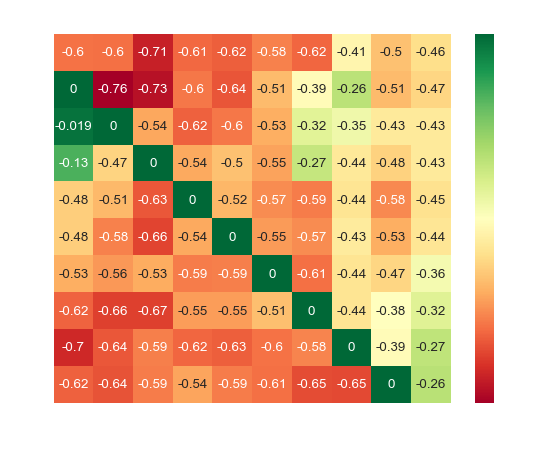

In [770]:
# Haga una copia de return_matrix y convierta el índice y las columnas al tipo de cadena
valores_dd = dd_matrix.copy()
valores_dd.index = valores_dd.index.astype(str)
valores_dd.columns = valores_dd.columns.astype(str)

# Convertir valores a tipo flotante
valores_dd = valores_dd.astype(float)

# Cambiamos el estilo del gráfico y establecemos el esquema de color predeterminado
plt.style.use('dark_background')
sns.set_palette("bright")

sns.heatmap(valores_dd, annot=True, cmap='RdYlGn')

# Agregamos títulos a los ejes
plt.xlabel('Media Movil Lenta', fontsize=12, color='white')
plt.ylabel('Media Movil Rapida', fontsize=12, color='white')

plt.title('Mapa de calor de drawdowns', fontsize=16, color='white')

# Cambiamos el tamaño de la fuente a 10 y el color a blanco
sns.set(font_scale=0.8, rc={'text.color':'white', 'axes.labelcolor':'white', 'xtick.color':'white', 'ytick.color':'white'})

# Cambiamos el color de fondo del gráfico a negro
fig = plt.gcf()
fig.set_facecolor('#0000')

plt.show()

Nuevamente, vemos métricas positivas en estrategias que funcionan con 40 y 200 LTMA para este activo. Por otro lado, la matriz presenta altas reducciones para números rápidos como STMA:5//LTMA:10 o STMA:7//LTMA:9.

# Pensamientos finales

A través del estudio realizado se puede observar cómo la elección de diferentes medias móviles puede afectar a los resultados de la estrategia. Sin embargo, se debe tener mucho cuidado al parametrizar posibles estrategias, ya que el estudio muestra resultados sobre cotizaciones pasadas (ver in-sample vs out-of-sample para más información).

Además, es muy importante tener en cuenta que para aplicar esta estrategia en un entorno real, se deben sumar al análisis las comisiones, así como el efecto de deslizamiento. Esto probablemente reduce el rendimiento de las estrategias, pero sería posible agregar otras reglas, como invertir a una tasa libre de riesgo cuando no se opera, vender en corto cuando se observa una señal de venta, etc.